# Load Data

In [28]:
import numpy as np
import glob
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from sklearn.metrics import accuracy_score
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [29]:
birds_labels = {
    "other": 0,
    "comcuc": 1,
    "cowpig1": 2,
    "eucdov": 3,
    "eueowl1": 4,
    "grswoo": 5,
    "tawowl1": 6
}

birds = [bird for bird in list(birds_labels.keys()) if bird != "other"]

In [30]:
def unique_rows(matrix):
    indexes = []
    labels = []
    
    for i, row in enumerate(matrix):
        if np.unique(row).size == 1:
            indexes.append(i)
            labels.append(np.unique(row)[0])
    
    indexes = np.array(indexes)
    labels = np.array(labels)
    
    return indexes, labels

In [31]:
def load_data(bird):
    labels = []
    features = []
    bird_id = birds_labels[bird]
    
    path = f'./data/{bird}/'
    labels_files = glob.glob(path + '*labels.npy')
    counter = None
    
    for i, file in enumerate(labels_files):
        print(f'{bird}: {i + 1}/{len(labels_files)}', end='\r')
        counter = i
        data_id = path + ''.join(file.split(".labels.npy")).split('/')[-1] + '.npy'
        
        annotations = np.load(file)
        feature = np.load(data_id)
        
        ind, label = unique_rows(annotations)
        
        if len(ind) == 0:
            continue
        
        labels.append(label)
        features.append(feature[ind])

    print('\n')
    labels = np.concatenate(labels)
    features = np.concatenate(features)
    
    return labels, features

In [32]:
X = []
y = []

for bird in birds:
    labels, features = load_data(bird)
    X.append(features)
    y.append(labels)
    
X = np.concatenate(X)
y = np.concatenate(y)

comcuc: 200/200

cowpig1: 200/200

eucdov: 200/200

eueowl1: 200/200

grswoo: 200/200

tawowl1: 200/200



# Load Test Data

In [33]:
def load_data():
    path = f'./python'
    files = glob.glob(path + '/test*.npy')
    files = sorted(files)
    
    result = []
    labels = [file.split('/')[-1].replace('.npy', '') for file in files]
    
    for i, file in enumerate(files):
        print(f"Loaded {i + 1}/{len(files)} test files.", end="\r")
        data = np.load(file)
        result.append(data)
        
    result = np.array(result)
    
    return result, labels

In [34]:
test_data, labels = load_data()

# Normalize Data

In [35]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [36]:
test_data = np.array([scaler.fit_transform(arr) for arr in test_data])

# Create Binary Dataset

In [37]:
X_hier = X.copy()
y_hier = np.where(y == 0, 0, 1)

# Create a Binary Neural Network Classifier

### Neural Network

In [11]:
# class BinaryClassifier(nn.Module):
#     def __init__(self, input_dim):
#         super(BinaryClassifier, self).__init__()
        
#         # Input layer to hidden layer 1
#         self.fc1 = nn.Linear(input_dim, 64)
        
#         # Hidden layer 1 to hidden layer 2
#         self.fc2 = nn.Linear(64, 128)
        
#         # Hidden layer 2 to hidden layer 3
#         self.fc3 = nn.Linear(128, 64)
        
#         # Hidden layer 3 to output layer
#         self.fc4 = nn.Linear(64, 1)
        
#         # Dropout layer with 50% drop probability
#         self.dropout = nn.Dropout(p=0.5)
    
#     def forward(self, x):
#         x = F.relu(self.fc1(x))  # ReLU activation function on first hidden layer
#         x = self.dropout(x)      # Dropout
        
#         x = F.relu(self.fc2(x))  # ReLU activation function on second hidden layer
#         x = self.dropout(x)      # Dropout
        
#         x = F.relu(self.fc3(x))  # ReLU activation function on third hidden layer
#         x = self.dropout(x)      # Dropout
        
#         x = torch.sigmoid(self.fc4(x))  # Sigmoid activation function on the output layer
#         return x
    
    
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))  
        x = self.dropout(x)      
        
        x = F.relu(self.fc2(x))  
        x = self.dropout(x)      
        
        x = F.relu(self.fc3(x)) 
        x = self.dropout(x)      
        
        x = F.relu(self.fc4(x))  
        x = self.dropout(x)      
        
        x = torch.sigmoid(self.fc5(x))  
        return x

### Hyperparameters

In [12]:
# Define the hyperparameters
learning_rate = 1e-5
batch_size = 64
num_epochs = 250

# from sklearn.utils.class_weight import compute_class_weight

# # Assuming y is your vector of labels
# classes = np.unique(y)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
# class_weights = torch.tensor(weights, dtype=torch.float)

### Training Procedure

In [13]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

# Assuming X is your feature matrix and Y are the labels
X_train, X_test, y_train, y_test = train_test_split(X_hier, y_hier, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)  # Change to float
y_test = torch.from_numpy(y_test).float().to(device)  # Change to float

# Create the DataLoader for training and test sets
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = BinaryClassifier(input_dim=548).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_f1 = 0.0
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
losses = []
f1_scores = []
accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs).squeeze()  # Squeeze the output tensor
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Evaluate the model
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predicted_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).squeeze()  # Squeeze the output tensor
            predicted = (outputs > 0.5).float()  # Threshold the output at 0.5
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    epoch_acc = correct / total
    epoch_f1 = f1_score(true_labels, predicted_labels, average='macro')

    # deep copy the model
    if epoch_f1 > best_f1:
        best_f1 = epoch_f1
        best_model_wts = copy.deepcopy(model.state_dict())

    losses.append(epoch_loss)
    f1_scores.append(epoch_f1)
    accuracies.append(epoch_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.5f}, Accuracy: {epoch_acc:.5f}, F1-score: {epoch_f1:.5f}')

print('Best Accuracy: {:5f}, Best F1-score: {:5f}'.format(best_acc, best_f1))

# load best model weights
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'model1.pth')


mps
Epoch 1/250, Loss: 0.63444, Accuracy: 0.78047, F1-score: 0.43835
Epoch 2/250, Loss: 0.44324, Accuracy: 0.78047, F1-score: 0.43835
Epoch 3/250, Loss: 0.34244, Accuracy: 0.78047, F1-score: 0.43835
Epoch 4/250, Loss: 0.29680, Accuracy: 0.78047, F1-score: 0.43835
Epoch 5/250, Loss: 0.26623, Accuracy: 0.93281, F1-score: 0.89175
Epoch 6/250, Loss: 0.23907, Accuracy: 0.95509, F1-score: 0.93262
Epoch 7/250, Loss: 0.20986, Accuracy: 0.95924, F1-score: 0.94012
Epoch 8/250, Loss: 0.18291, Accuracy: 0.96117, F1-score: 0.94342
Epoch 9/250, Loss: 0.16216, Accuracy: 0.96287, F1-score: 0.94594
Epoch 10/250, Loss: 0.14488, Accuracy: 0.96462, F1-score: 0.94849
Epoch 11/250, Loss: 0.13677, Accuracy: 0.96550, F1-score: 0.94973
Epoch 12/250, Loss: 0.12815, Accuracy: 0.96678, F1-score: 0.95154
Epoch 13/250, Loss: 0.12321, Accuracy: 0.96737, F1-score: 0.95242
Epoch 14/250, Loss: 0.11749, Accuracy: 0.96842, F1-score: 0.95388
Epoch 15/250, Loss: 0.11468, Accuracy: 0.96877, F1-score: 0.95433
Epoch 16/250, L

Epoch 125/250, Loss: 0.05112, Accuracy: 0.98018, F1-score: 0.97082
Epoch 126/250, Loss: 0.05193, Accuracy: 0.98006, F1-score: 0.97066
Epoch 127/250, Loss: 0.05269, Accuracy: 0.98018, F1-score: 0.97082
Epoch 128/250, Loss: 0.05216, Accuracy: 0.98006, F1-score: 0.97063
Epoch 129/250, Loss: 0.05143, Accuracy: 0.98018, F1-score: 0.97077
Epoch 130/250, Loss: 0.05150, Accuracy: 0.97988, F1-score: 0.97038
Epoch 131/250, Loss: 0.05191, Accuracy: 0.98018, F1-score: 0.97082
Epoch 132/250, Loss: 0.05305, Accuracy: 0.98000, F1-score: 0.97054
Epoch 133/250, Loss: 0.05054, Accuracy: 0.98023, F1-score: 0.97088
Epoch 134/250, Loss: 0.05096, Accuracy: 0.97988, F1-score: 0.97037
Epoch 135/250, Loss: 0.05238, Accuracy: 0.98006, F1-score: 0.97063
Epoch 136/250, Loss: 0.05352, Accuracy: 0.98029, F1-score: 0.97100
Epoch 137/250, Loss: 0.05162, Accuracy: 0.98018, F1-score: 0.97082
Epoch 138/250, Loss: 0.05044, Accuracy: 0.98018, F1-score: 0.97078
Epoch 139/250, Loss: 0.05075, Accuracy: 0.98012, F1-score: 0.9

Epoch 248/250, Loss: 0.04002, Accuracy: 0.98123, F1-score: 0.97242
Epoch 249/250, Loss: 0.03819, Accuracy: 0.98158, F1-score: 0.97290
Epoch 250/250, Loss: 0.03935, Accuracy: 0.98129, F1-score: 0.97247
Best Accuracy: 0.000000, Best F1-score: 0.973260


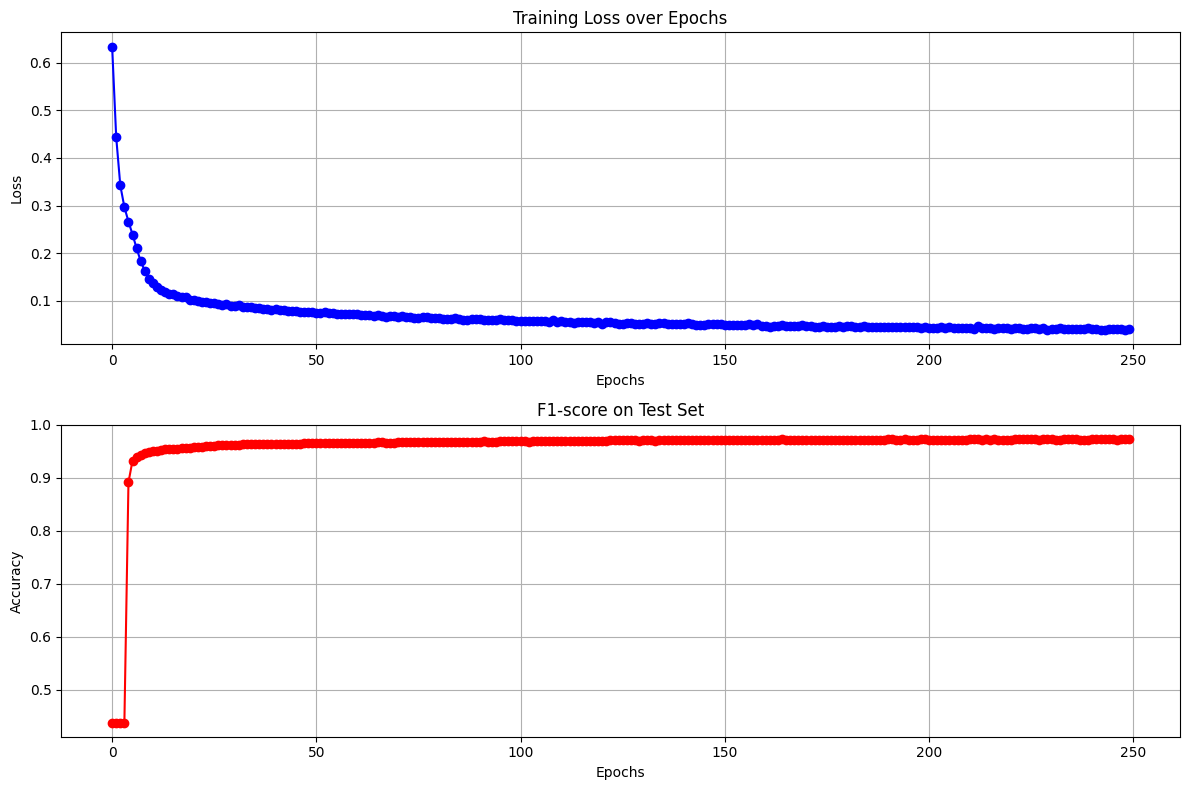

In [14]:
epochs = range(num_epochs)

# Creating subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))

# Plotting loss
ax1.plot(epochs, losses, color='blue', marker='o')
ax1.set_title('Training Loss over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Plotting accuracy
ax2.plot(epochs, f1_scores, color='red', marker='o')
ax2.set_title('F1-score on Test Set')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)

# Adjusting the layout and showing the plots
plt.tight_layout()
plt.show()


# Test Data

In [144]:
# Assuming X_unlabeled is a numpy array
X_unlabeled = torch.from_numpy(test_data).float().to(device)

# Create a DataLoader for the unlabeled data
unlabeled_dataset = TensorDataset(X_unlabeled)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False)


# Prediction function
def predict(model, unlabeled_loader):
    model.eval()  # Ensure the model is in evaluation mode
    result = []
    predictions = []

    with torch.no_grad():
        for sample in test_data:
            X_unlabeled = torch.from_numpy(sample).float().to(device)
            # Create a DataLoader for the unlabeled data
            unlabeled_dataset = TensorDataset(X_unlabeled)
            unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False)
            
            for inputs in unlabeled_loader:
                inputs = inputs[0].to(device)
                outputs = model(inputs)  # Pass data through model
                predicted = (outputs > 0.5).float() # Get the predicted classes
                predictions.extend(predicted.cpu().numpy().tolist())  # Add the predictions to our list
            
            result.append(predictions)
            predictions = []

    return np.array(result)

# Predict
predictions = predict(model, unlabeled_loader).astype(int)
np.count_nonzero(predictions)


11404

In [145]:
sub = ""

for i, prediction in enumerate(predictions):
    y_pred = prediction.astype(str).flatten()
    
    y_str = ','.join(y_pred)
    result = f'{labels[i]},{y_str}\n'
    sub += result
    
sub

'test00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,0,1,1,1,1,0,0,0,0,1,0,1,1,0,0,0,1,1,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,1,1,1,0,0,0,0,1,0,1,1,0,0,0,1,1,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,

# Classifying Birds

### Preprocessing

In [38]:
X_class = X[y != 0].copy()
y_class = np.delete(y, np.where(y == 0)) - 1

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_class, y_class)
something = SelectFromModel(clf, prefit=True, max_features=128)
X_class = something.transform(X_class)
np.where(something.get_support())

(array([  0,   3,   4,   6,   8,   9,  11,  12,  13,  15,  16,  17,  18,
         19,  20,  21,  22,  23,  24,  25,  27,  28,  29,  30,  31,  32,
         33,  34,  35,  36,  37,  38,  39,  40,  46,  47,  69,  70,  71,
         72,  73,  74,  75,  79,  80,  81,  82,  83,  84,  85,  87,  95,
        109, 127, 130, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153, 154, 155, 156, 236, 256, 258, 268,
        270, 271, 272, 273, 274, 278, 285, 286, 287, 288, 289, 290, 292,
        293, 294, 295, 296, 297, 305, 306, 345, 346, 347, 348, 349, 350,
        351, 361, 372, 404, 410, 411, 412, 413, 414, 415, 416, 417, 418,
        419, 420, 422, 462, 502, 522, 536, 537, 538, 539, 544]),)

### Neural Network

In [39]:
# class BirdClassifier(nn.Module):
#     def __init__(self, input_dim):
#         super(BirdClassifier, self).__init__()
        
#         # Input layer to hidden layer 1
#         self.fc1 = nn.Linear(input_dim, 64)
        
#         # Hidden layer 1 to hidden layer 2
#         self.fc2 = nn.Linear(64, 128)
        
#         # Hidden layer 2 to hidden layer 3
#         self.fc3 = nn.Linear(128, 64)
        
#         # Hidden layer 3 to output layer
#         self.fc4 = nn.Linear(64, 6) # 6 output units for 6 bird classes
        
#         # Dropout layer with 50% drop probability
#         self.dropout = nn.Dropout(p=0.5)
    
#     def forward(self, x):
#         x = F.relu(self.fc1(x))  # ReLU activation function on first hidden layer
#         x = self.dropout(x)      # Dropout
        
#         x = F.relu(self.fc2(x))  # ReLU activation function on second hidden layer
#         x = self.dropout(x)      # Dropout
        
#         x = F.relu(self.fc3(x))  # ReLU activation function on third hidden layer
#         x = self.dropout(x)      # Dropout
        
#         x = self.fc4(x)  # No activation function here as we will use CrossEntropyLoss
#         return x

class BirdClassifier(nn.Module):
    def __init__(self):
        super(BirdClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(64) 
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(128)  
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(256) 
        self.pool = nn.MaxPool1d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 6)  # 6 output classes

    def forward(self, x):
        x = x.unsqueeze(1)  
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) 
        x = self.pool(F.relu(self.bn3(self.conv3(x)))) 
        x = x.view(x.size(0), -1)
        x = F.dropout(F.relu(self.fc1(x)), p=0.2, training=self.training) 
        x = F.dropout(F.relu(self.fc2(x)), p=0.2, training=self.training) 
        x = self.fc3(x)
        return x



### Hyperparameters

In [40]:
# Define the hyperparameters
learning_rate = 1e-5
batch_size = 64
num_epochs = 250

# from sklearn.utils.class_weight import compute_class_weight

# # Assuming y is your vector of labels
# classes = np.unique(y)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
# class_weights = torch.tensor(weights, dtype=torch.float)

### Training

In [41]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

# Assuming X is your feature matrix and Y are the labels
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Apply SMOTE

# Convert the data to PyTorch tensors
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)  # Change to long
y_test = torch.from_numpy(y_test).long().to(device)    # Change to long

# Create the DataLoader for training and test sets
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = BirdClassifier().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_f1 = 0.0
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
losses = []
f1_scores = []
accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Evaluate the model
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predicted_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    epoch_acc = correct / total
    epoch_f1 = f1_score(true_labels, predicted_labels, average='macro')

    # deep copy the model
    if epoch_f1 > best_f1:
        best_f1 = epoch_f1
        best_model_wts = copy.deepcopy(model.state_dict())

    losses.append(epoch_loss)
    f1_scores.append(epoch_f1)
    accuracies.append(epoch_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.5f}, Accuracy: {epoch_acc:.5f}, F1-score: {epoch_f1:.5f}')

print('Best Accuracy: {:5f}, Best F1-score: {:5f}'.format(best_acc, best_f1))

# load best model weights
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'model2.pth')

mps
Epoch 1/250, Loss: 1.02101, Accuracy: 0.80914, F1-score: 0.79469
Epoch 2/250, Loss: 0.48321, Accuracy: 0.85942, F1-score: 0.85125
Epoch 3/250, Loss: 0.37612, Accuracy: 0.87808, F1-score: 0.87296
Epoch 4/250, Loss: 0.32211, Accuracy: 0.89186, F1-score: 0.89002
Epoch 5/250, Loss: 0.28747, Accuracy: 0.90403, F1-score: 0.90421
Epoch 6/250, Loss: 0.26006, Accuracy: 0.91268, F1-score: 0.91479
Epoch 7/250, Loss: 0.23628, Accuracy: 0.91349, F1-score: 0.91288
Epoch 8/250, Loss: 0.21346, Accuracy: 0.92160, F1-score: 0.92184
Epoch 9/250, Loss: 0.19669, Accuracy: 0.92322, F1-score: 0.92611
Epoch 10/250, Loss: 0.18178, Accuracy: 0.92971, F1-score: 0.93210
Epoch 11/250, Loss: 0.16757, Accuracy: 0.92836, F1-score: 0.92849
Epoch 12/250, Loss: 0.15438, Accuracy: 0.93350, F1-score: 0.93602
Epoch 13/250, Loss: 0.14018, Accuracy: 0.93701, F1-score: 0.93985
Epoch 14/250, Loss: 0.13319, Accuracy: 0.93890, F1-score: 0.94109
Epoch 15/250, Loss: 0.12341, Accuracy: 0.93890, F1-score: 0.94204
Epoch 16/250, L

Epoch 125/250, Loss: 0.00014, Accuracy: 0.96188, F1-score: 0.96178
Epoch 126/250, Loss: 0.00041, Accuracy: 0.96377, F1-score: 0.96518
Epoch 127/250, Loss: 0.00015, Accuracy: 0.96296, F1-score: 0.96256
Epoch 128/250, Loss: 0.00017, Accuracy: 0.96080, F1-score: 0.96064
Epoch 129/250, Loss: 0.00012, Accuracy: 0.96269, F1-score: 0.96224
Epoch 130/250, Loss: 0.00010, Accuracy: 0.96215, F1-score: 0.96302
Epoch 131/250, Loss: 0.00010, Accuracy: 0.96350, F1-score: 0.96380
Epoch 132/250, Loss: 0.00011, Accuracy: 0.96377, F1-score: 0.96422
Epoch 133/250, Loss: 0.00020, Accuracy: 0.96188, F1-score: 0.96300
Epoch 134/250, Loss: 0.00226, Accuracy: 0.96161, F1-score: 0.96327
Epoch 135/250, Loss: 0.00075, Accuracy: 0.96134, F1-score: 0.96240
Epoch 136/250, Loss: 0.00031, Accuracy: 0.96323, F1-score: 0.96514
Epoch 137/250, Loss: 0.00013, Accuracy: 0.96513, F1-score: 0.96630
Epoch 138/250, Loss: 0.00012, Accuracy: 0.96513, F1-score: 0.96588
Epoch 139/250, Loss: 0.00010, Accuracy: 0.96296, F1-score: 0.9

Epoch 248/250, Loss: 0.00013, Accuracy: 0.96621, F1-score: 0.96707
Epoch 249/250, Loss: 0.00010, Accuracy: 0.96323, F1-score: 0.96436
Epoch 250/250, Loss: 0.00032, Accuracy: 0.96134, F1-score: 0.96289
Best Accuracy: 0.000000, Best F1-score: 0.967492


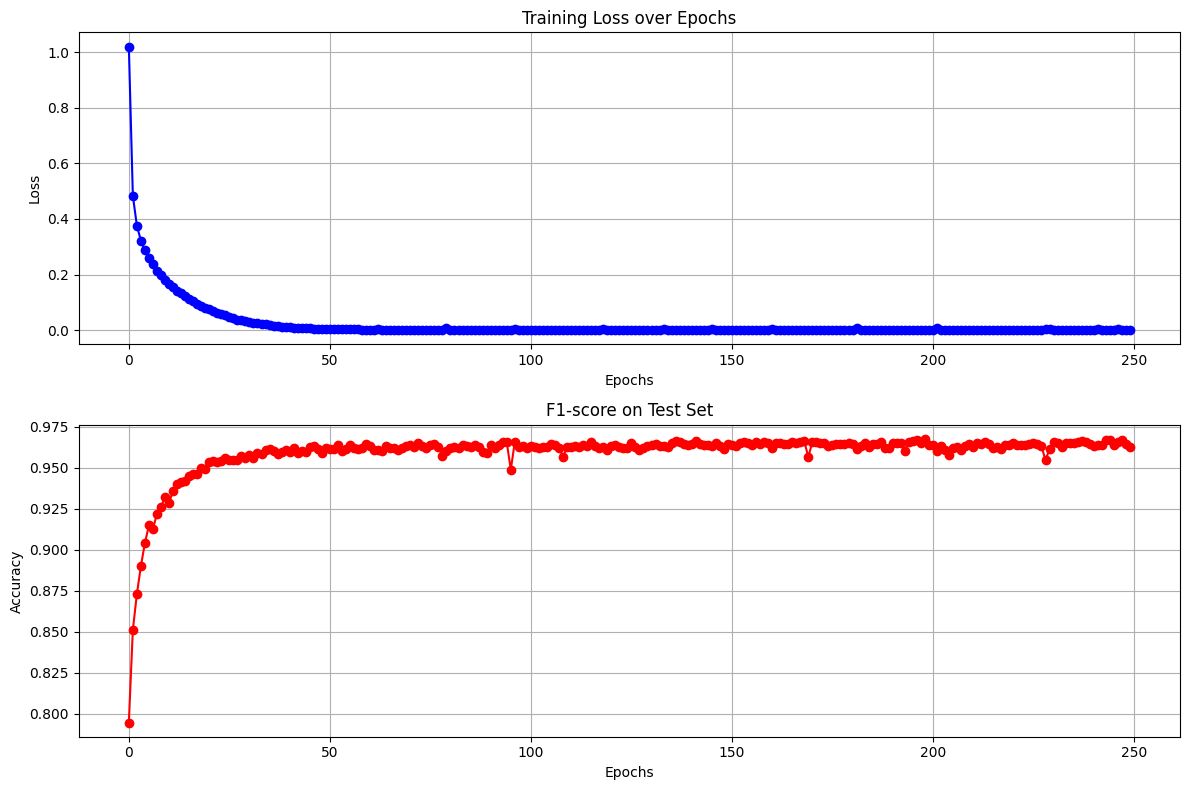

In [42]:
epochs = range(num_epochs)

# Creating subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))

# Plotting loss
ax1.plot(epochs, losses, color='blue', marker='o')
ax1.set_title('Training Loss over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Plotting accuracy
ax2.plot(epochs, f1_scores, color='red', marker='o')
ax2.set_title('F1-score on Test Set')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)

# Adjusting the layout and showing the plots
plt.tight_layout()
plt.show()